In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
n_train = 50  # number of train samples
x_train, _ = torch.sort(torch.rand(n_train) * 5)  # x_train.shape = [n_train,]

In [3]:
def f(x):
    return 2 * torch.sin(x) + x ** 0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # y_train.shape = [n_train,]
x_test = torch.arange(0, 5, 0.1)  # x_test.shape = [n_test,]
y_truth = f(x_test)  # shape = [n_test,]
n_test = len(x_test)
n_test

50

In [4]:
def plot_kernel_reg(y_hat):  # y_hat.shape = [n_test,]
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'], xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

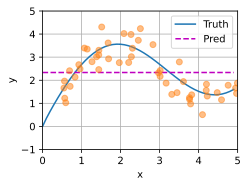

In [5]:
# y_train.mean()的shape为[], y_hat的shape为[n_test,], 
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

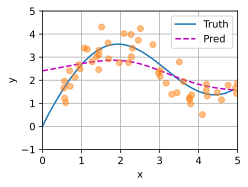

In [6]:
# x_test.repeat_interleave(n_train)的shape是[n_test * n_train]
# 经过reshape后，X_repeat的shape是[n_test, n_train]，每列是x_test
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# X_repeat的shape是[n_test, n_train]，x_train的shape是[n_train,]，
# 因此X_repeat - x_train时，x_train被广播，被复制n_test次，每行是一个x_train。
# 由于X_repeat每列是一个x_test，因此X_repeat - x_train得到的是x_test的每一个元素和x_train的每一个元素相减
# 得到的shape为[n_test, n_train]
# 由于attention_weights每行元素要与y_train做点击，即对y_train的元素求加权和，因此attention_weights要按行归一化
# 即softmax的dim=1，即行和为1
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的shape为[n_test, 1]
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

repeat和repeat_interleave的区别
* repeat是将矢量x首尾相接重复n次，如[1, 2, 3, 1, 2, 3]
* repeat_interleave是将矢量每个元素重复n次，再拼接起来，如[1, 1, 2, 2, 3, 3]

以下两者等价
* x_test.repeat_interleave(n_train).reshape((-1, n_train))
* x_test.repeat(n_train).reshape((-1, n_test)).T

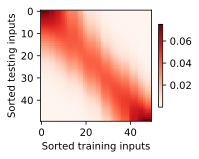

In [15]:
# attention_weights.unsqueeze(0).unsqueeze(0)的shape为[1, 1, n_test, n_train]
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

In [16]:
X = torch.ones((2, 1, 4))  # 2个1*4的矩阵
Y = torch.ones((2, 4, 6))  # 2个4*6的矩阵
torch.bmm(X, Y).shape  # 2个1*6的矩阵

torch.Size([2, 1, 6])

In [18]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [31]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True))  # shape = [1]
    
    # queries.shape = [n_train], keys.shape = [n_train, n_train - 1], 
    # values.shape = [n_train, n_train - 1]
    def forward(self, queries, keys, values):
        # queries.shape = [n_train, n_train - 1]，每列都是x_train，复制了n_train - 1份
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        # keys.shape = [n_train, n_train - 1]，每行都是x_train
        # 第n行是x_train除了第n个元素之外的n_train - 1个元素
        # (queries - keys)计算了x_train的元素两两之间的差，除了相同元素之间之外，然后对每行做归一化
        # attention_weights.shape = [n_train, n_train - 1]
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)
        # attention_weights.unsqueeze(1)的shape为[n_train, 1, n_train - 1]
        # values.shape = [n_train, n_train - 1]，每行都是y_train
        # 第n行是y_train除了第n个元素之外的n_train - 1个元素
        # values.unsqueeze(-1)的shape为[n_train, n_train - 1, 1]
        # torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1))的shape为[n_train, 1]
        # 相当于对每个query（一共n_train个query），都对y_train进行加权求和
        # 输出的shape为[n_train]
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [24]:
# x_train的shape为[n_train]，x_train.repeat((n_train, 1))在dim=1上复制1份x_train，在dim=0上复制n_train份x_train，因此X_tile的shape为[n_train, n_train]
X_tile = x_train.repeat((n_train, 1))  # [n_train, n_train]，每行都是一个x_train
Y_tile = y_train.repeat((n_train, 1))  # [n_train, n_train]，每行都是一个y_train
# (1 - torch.eye(n_train)).type(torch.bool)是个[n_train, n_train]的矩阵，对角线为False，其余为True
# X_tile[(1 - torch.eye(n_train)).type(torch.bool)]为[n_train * (n_train - 1)]
# keys的shape为[n_train, n_train - 1]，第n行都是x_train除了第n个元素之外的n_train - 1个元素
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的shape为[n_train, n_train - 1]，第n行都是y_train除了第n个元素之外的n_train - 1个元素
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

repeat函数的输入和输出的shape的关系
* 如果输入的shape为[a, b], repeat参数为[c, d, e]，则输出的shape为[c, a\*d, b\*e]

epoch 4, loss: 8.521997


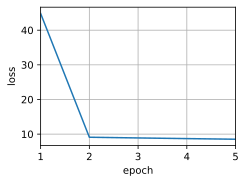

In [37]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    # x_train.shape = [n_train], keys.shape = [n_train, n_train - 1], 
    # values.shape = [n_train, n_train - 1], y_train.shape = [n_train]
    # net(x_train, keys, values).shape = [n_train], l.shape = [n_train]
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    animator.add(epoch + 1, float(l.sum()))
    print(f'epoch {epoch}, loss: {float(l.sum()):.6f}')

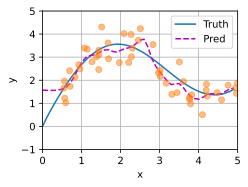

In [38]:
keys = x_train.repeat((n_test, 1))  # [n_test, n_train]
values = y_train.repeat((n_test, 1))  # [n_test, n_train]
# 对于x_test的第n个元素，计算它和x_train的每个元素的attention，并进行归一化，对y_train求加权和，得到y_hat的第n个元素
# 这里做预测时，需要用到训练数据
y_hat = net(x_test, keys, values).unsqueeze(1).detach()  # [n_test]
plot_kernel_reg(y_hat)

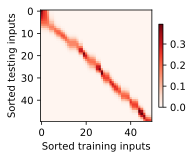

In [39]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0), xlabel='Sorted training inputs', ylabel='Sorted testing inputs')